## Importamos librerias


In [214]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error, accuracy_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor, XGBClassifier
import joblib


## Load Data

In [215]:
df = pd.read_csv('/workspaces/carlossuesc95-intro-ml/data/raw/internal-link. Regresion Lineal.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.548
1334,18,female,31.920,0,no,northeast,2205.981
1335,18,female,36.850,0,no,southeast,1629.833
1336,21,female,25.800,0,no,southwest,2007.945


## EDA

### Eliminacion
1. columnas constantes
2. valores duplicados
3. columnas redundantes
4. missing values, NAN ó 0 escondidos
5. outliers

### 1. Constantes

In [216]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
0
1
2
3
4
...
1333
1334
1335
1336


### 2. Duplicados

In [217]:
# Comprobar duplicados
dupl_data = df.duplicated().sum()
if dupl_data != 0:
    print(f"Se encontro {dupl_data} duplicado que ha sido eliminado")
    df.drop_duplicates(inplace=True)
else:
    print(f"No hay duplicados")

Se encontro 1 duplicado que ha sido eliminado


### 3. Redundantes, no hay 

### 4. Missing values, NaN o 0 

In [218]:
print(df.isna().sum())
zeros = df == 0
percent_ceros = zeros.mean() * 100
print(percent_ceros)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
age         0.000
sex         0.000
bmi         0.000
children   42.857
smoker      0.000
region      0.000
charges     0.000
dtype: float64


<Axes: >

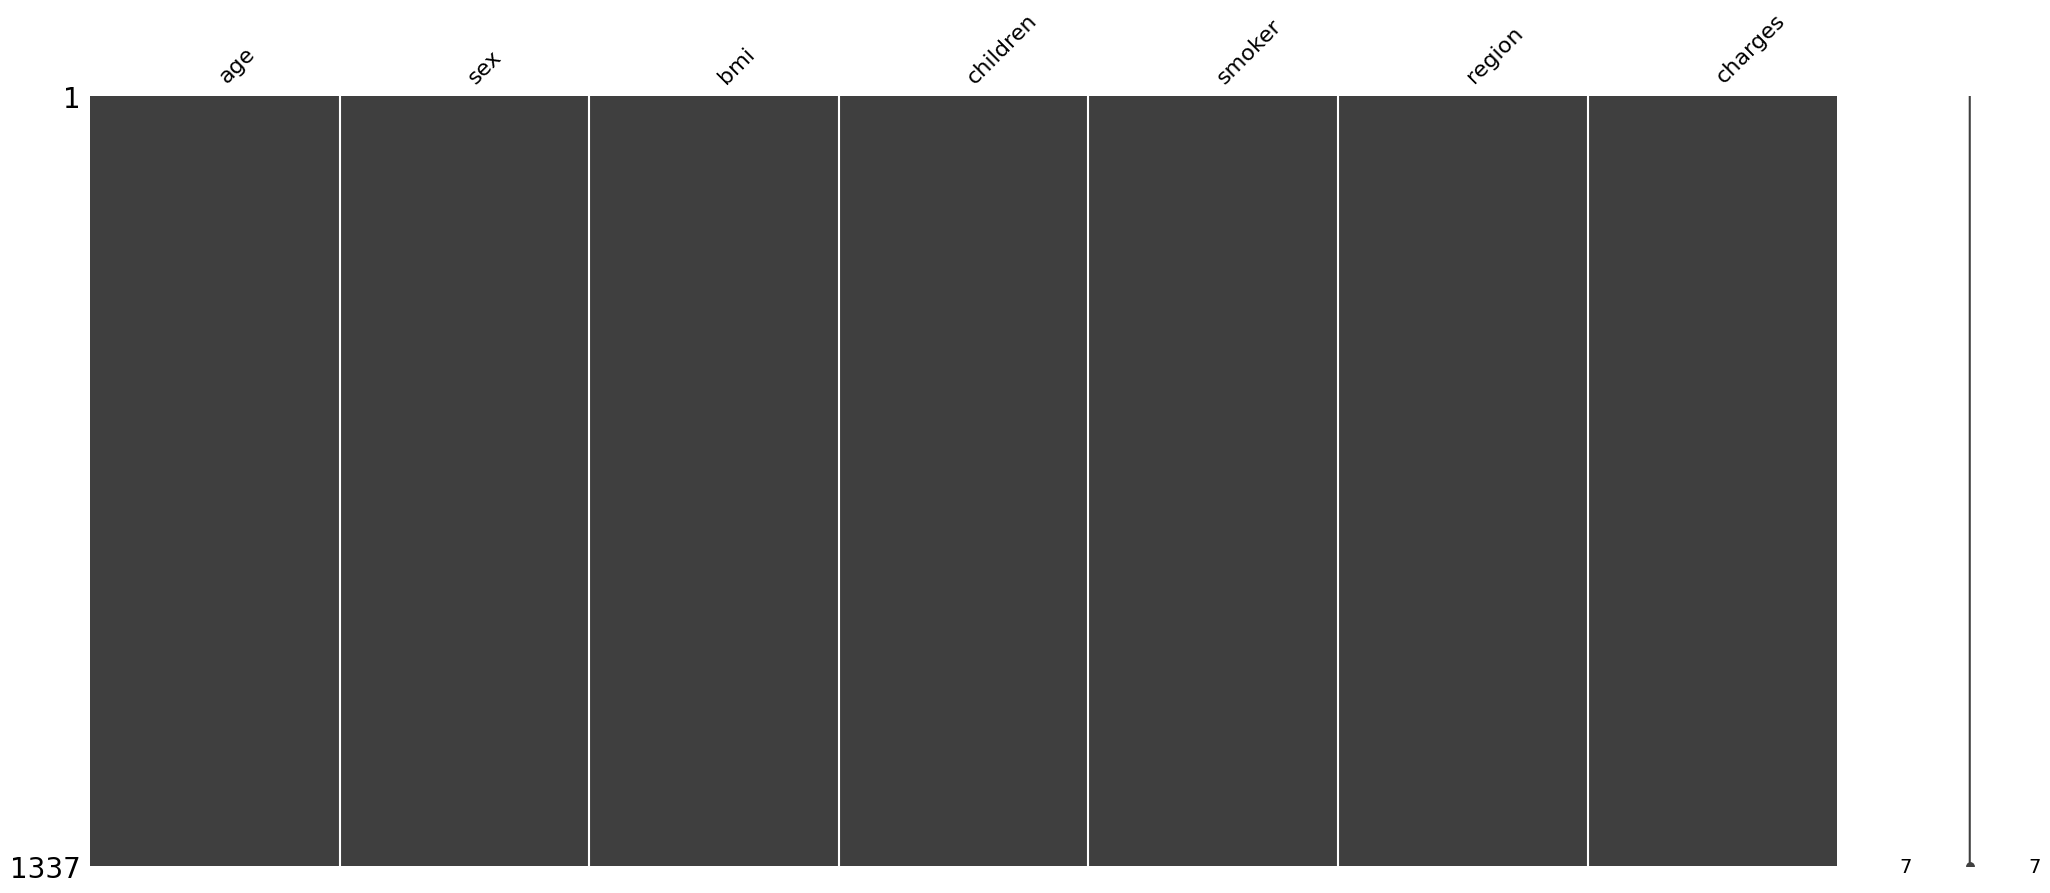

In [219]:
msno.matrix(df)

#### Parece que la columna children tiene 42% de 0 pero tener ese dato es correcto.

### Codificación de variables categóricas


In [220]:
variables = df.select_dtypes(include=['object', 'category']).columns.tolist()
variables

['sex', 'smoker', 'region']

In [221]:
# map manual para variable sex y smoker
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})   
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.924
1,18,0,33.770,1,0,southeast,1725.552
2,28,0,33.000,3,0,southeast,4449.462
3,33,0,22.705,0,0,northwest,21984.471
4,32,0,28.880,0,0,northwest,3866.855


### One-hot encoding para 'region'

In [222]:
df_dummies = pd.get_dummies(df['region'], drop_first=True,dtype=int)
df = pd.concat([df, df_dummies], axis=1)
df.drop('region', axis=1, inplace=True)
df

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,1,27.900,0,1,16884.924,0,0,1
1,18,0,33.770,1,0,1725.552,0,1,0
2,28,0,33.000,3,0,4449.462,0,1,0
3,33,0,22.705,0,0,21984.471,1,0,0
4,32,0,28.880,0,0,3866.855,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.548,1,0,0
1334,18,1,31.920,0,0,2205.981,0,0,0
1335,18,1,36.850,0,0,1629.833,0,1,0
1336,21,1,25.800,0,0,2007.945,0,0,1


### 5. Outliers

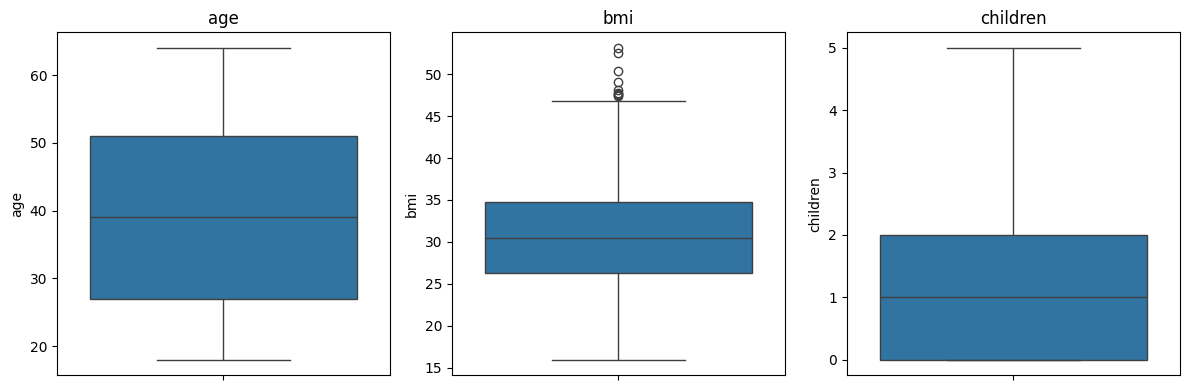

In [223]:
#Hacemos el estudio de outliers en las columnas que puede haber outliers
cols_outliers = ['age', 'bmi', 'children']

plt.figure(figsize=(12, 4))

for i, col in enumerate(cols_outliers, 1):
    plt.subplot(1, len(cols_outliers), i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


### Split Train Test

In [224]:
# Split train test
X= df.drop('charges',axis=1)
y= df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [225]:
iso = IsolationForest(random_state=42)
df_train_outliers = X_train.copy()
df_train_outliers['outlier_flag'] = iso.fit_predict(X_train)

In [226]:
df_train_outliers['outlier_flag'].value_counts()

outlier_flag
-1    678
 1    391
Name: count, dtype: int64

In [227]:
X

,age,sex,bmi,children,smoker,northwest,southeast,southwest
0,19,1,27.900,0,1,0,0,1
1,18,0,33.770,1,0,0,1,0
2,28,0,33.000,3,0,0,1,0
3,33,0,22.705,0,0,1,0,0
4,32,0,28.880,0,0,1,0,0
...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,1,0,0
1334,18,1,31.920,0,0,0,0,0
1335,18,1,36.850,0,0,0,1,0
1336,21,1,25.800,0,0,0,0,1


### StandarScaler para escalar los datos 

In [228]:
X_to_sc = X_train.copy()
X_test_to_sc = X_test.copy()

In [229]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_to_sc)
X_test_sc = scaler.transform(X_test_to_sc)

In [230]:
#RobustScaler

scaler2 = RobustScaler()
X_train_scrobust = scaler2.fit_transform(X_train)
X_test_scrobust = scaler2.transform(X_test)

### Metodo RandomForest

In [231]:
model = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1).fit(X_train,y_train)

In [232]:
#Importancia caract.
importances = model.feature_importances_/model.feature_importances_.sum()*100

#Convertir a dataframe
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

#importancia acumulada
df_rf_imp['rf_importance_accum'] = df_rf_imp['rf_importance'].cumsum()

df_rf_imp

,feature,rf_importance,rf_importance_accum
4,smoker,60.078,60.078
2,bmi,21.581,81.659
0,age,13.587,95.245
3,children,2.284,97.529
1,sex,0.679,98.208
6,southeast,0.657,98.864
5,northwest,0.656,99.521
7,southwest,0.479,100.000


### Metodo XGB 

In [233]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train, test_size=0.2,random_state=42)

model_xgb = XGBRegressor(objective='reg:squarederror',random_state=42).fit(X_train1,y_train1)

In [234]:
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [235]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp
     

,feature,perm_imp
4,smoker,61.196
0,age,54.386
3,children,10.894
2,bmi,6.938
6,southeast,1.190
5,northwest,0.617
7,southwest,-0.573
1,sex,-2.047


### Metodo SHAP

In [236]:
X_val_shap = X_val[X_train1.columns].copy()
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
model_lgbm.fit(X_train1, y_train1)

explainer = shap.Explainer(model_lgbm)   # usa el mismo X_val
shap_vals = explainer(X_val_shap,check_additivity=False).values

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 855, number of used features: 8
[LightGBM] [Info] Start training from score 13131.545132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [237]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_accum,perm_imp
5,smoker,60.078,60.078,61.196
1,bmi,21.581,81.659,6.938
0,age,13.587,95.245,54.386
2,children,2.284,97.529,10.894
4,sex,0.679,98.208,-2.047
6,southeast,0.657,98.864,1.190
3,northwest,0.656,99.521,0.617
7,southwest,0.479,100.000,-0.573


In [238]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_accum,perm_imp
5,smoker,60.078,60.078,61.196
1,bmi,21.581,81.659,6.938
0,age,13.587,95.245,54.386
2,children,2.284,97.529,10.894


In [239]:
features = df_filt['feature']
features

5      smoker
1         bmi
0         age
2    children
Name: feature, dtype: object

### Matrix de correlacion

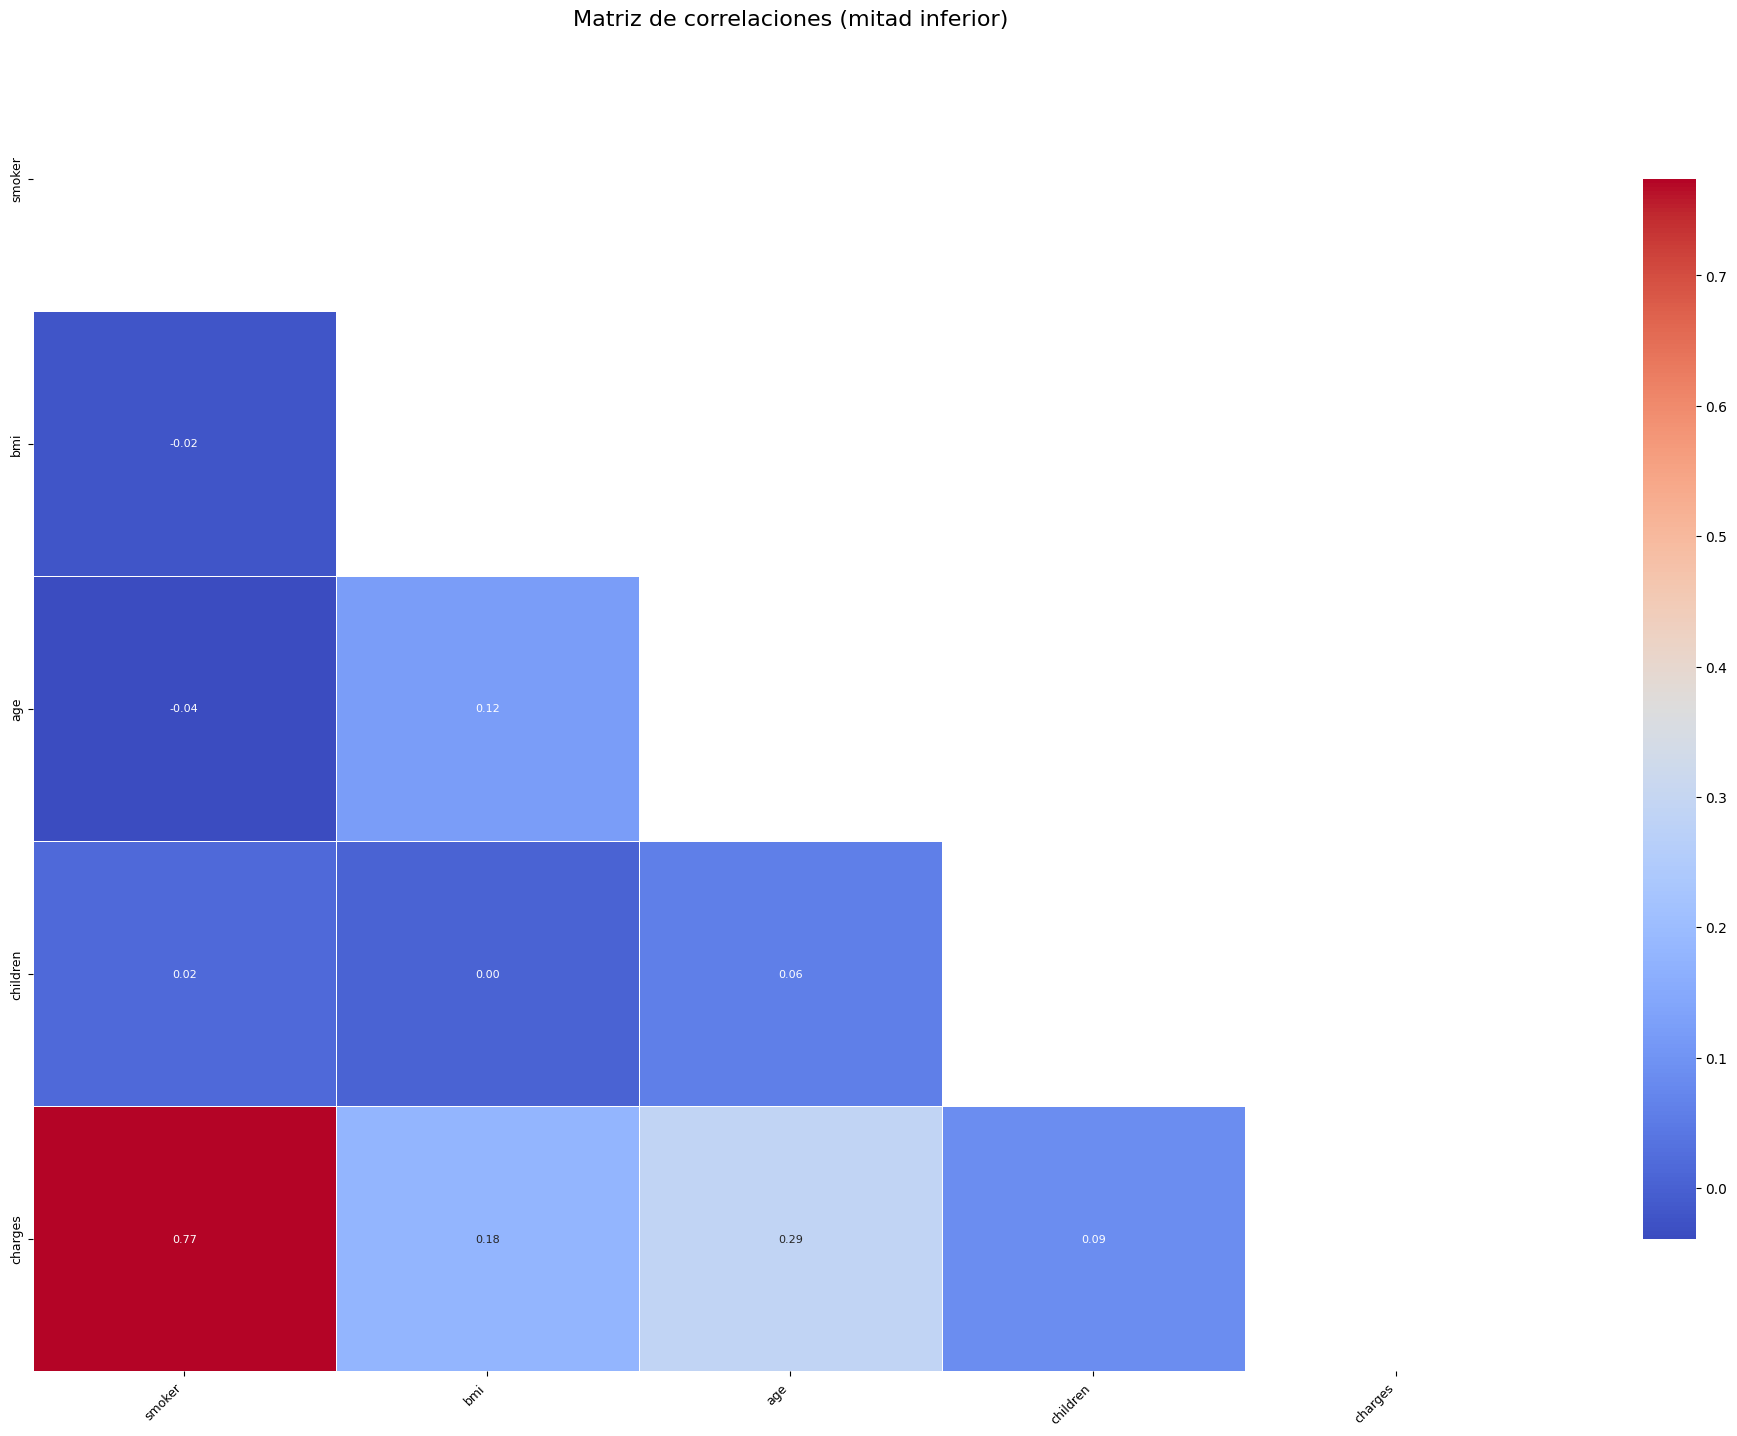

In [240]:
X_copy = X_train[features].copy()
X_copy['charges'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

### Cross Validation

In [241]:
# V1
cv_results1 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train[features], y_train, cv=3, scoring='r2')
cv_results1.mean()*1

np.float64(0.816006913172903)

In [242]:
# V2
cv_results2 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train[features].drop(['smoker'],axis=1), y_train, cv=3, scoring='r2')
cv_results2.mean()*-1

np.float64(0.04467714919762311)

### Modelo Regression lineal 

In [243]:
#Modelo Regresion Lineal con StandardScaler
model_rg = LinearRegression()
model_rg.fit(X_train_sc,y_train)
#Modelo Regresion Lineal con RobustScaler
model_rg_robust = LinearRegression()
model_rg_robust.fit(X_train_scrobust,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [244]:
y_pred = model_rg.predict(X_test_sc)
y_pred2 = model_rg_robust.predict(X_test_scrobust)
y_pred

array([ 8.14369388e+03,  5.73711568e+03,  1.43693149e+04,  3.17455136e+04,
        8.96238666e+03,  1.31497224e+04,  3.04467607e+04,  1.45328881e+03,
        1.06330184e+04,  1.13189438e+04,  1.03778536e+04,  3.31184377e+04,
        3.10772527e+04,  1.74119253e+04,  1.08016743e+04,  9.52889964e+03,
        4.16103784e+03,  3.17315373e+04,  3.21938875e+03,  5.22992460e+03,
        3.54979004e+03,  3.02837740e+04,  1.48989509e+04,  3.04569093e+04,
        3.11077668e+04,  5.51196081e+03,  3.55030401e+04,  3.65704810e+04,
        1.14123133e+04,  1.42056990e+04,  6.50234029e+03,  1.27246945e+04,
        3.99806590e+02,  1.20883980e+04,  3.96592069e+04,  1.23395540e+04,
        4.74412279e+03,  3.91903157e+03,  3.08606789e+04,  8.95870663e+03,
        7.05389441e+03,  3.01125636e+04,  3.47804324e+04,  1.22916189e+04,
        7.35739310e+03,  3.42060530e+03,  6.21243471e+03,  8.98345200e+03,
        4.26401828e+03,  9.01992870e+03,  6.60149578e+03,  1.20802337e+04,
        3.12447687e+04,  

In [245]:

print(f" Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f" r2: {r2_score(y_test, y_pred)}")

 Mean squared error: 35478020.67523558
 r2: 0.8069287081198013


In [246]:

print(f" Mean squared error: {mean_squared_error(y_test, y_pred2)}")
print(f" r2: {r2_score(y_test, y_pred2)}")

 Mean squared error: 35478020.67523561
 r2: 0.8069287081198011


In [247]:
joblib.dump(model_rg,'linear_model.pkl')

['linear_model.pkl']